### Elastic Net Optimal Technical Indicator Strategy
$\textbf{IDEA}$: Generate hundreds of technical indicators, then figure out what the most important indicators are using an elastic net regression with a variable alpha ratio. Do this for a rolling window. 


Begin by generating several hundred technical indicators.

In [355]:
#Generate hundres of technical indicators.
import numpy as np
import pandas as pd
from typing import Optional, Sequence, Union

# ---------- helpers ----------
def _safe_div(a, b):
    out = np.divide(a, b, out=np.full_like(a, np.nan, dtype="float64"), where=(b != 0) & np.isfinite(b))
    return out

def _ensure_series(close: Union[pd.Series, pd.DataFrame], name="close") -> pd.Series:
    if isinstance(close, pd.DataFrame):
        if "Close" in close.columns:
            close = close["Close"]
        elif close.shape[1] == 1:
            close = close.iloc[:, 0]
        else:
            raise ValueError("If you pass a DataFrame, it must have a 'Close' column or one column only.")
    close = pd.Series(close, name=name).astype("float64")
    close.index = pd.to_datetime(close.index)
    return close.sort_index()

def _mac(a, span):
    # Pandas ewm mean with common trading practice settings
    return pd.Series(a).ewm(span=span, adjust=False, min_periods=span).mean()

def _rsi(close: pd.Series, window: int) -> pd.Series:
    # Close-only RSI (Wilder’s)
    delta = close.diff()
    up = delta.clip(lower=0.0)
    down = -delta.clip(upper=0.0)
    rs = up.ewm(alpha=1/window, adjust=False, min_periods=window).mean() / \
         down.ewm(alpha=1/window, adjust=False, min_periods=window).mean()
    return 100 - (100 / (1 + rs))

def _rolling_percentile_rank(x: np.ndarray) -> float:
    # rank of last point within window (right-sided, ties -> max rank), scaled [0,1]
    arr = np.sort(x)
    r = np.searchsorted(arr, x[-1], side="right")
    return r / len(x)

def _rolling_pos_in_range(close: pd.Series, window: int) -> pd.Series:
    roll_max = close.rolling(window, min_periods=window).max()
    roll_min = close.rolling(window, min_periods=window).min()
    return _safe_div((close - roll_min).to_numpy(), (roll_max - roll_min).to_numpy())

def _macd(close: pd.Series, fast: int, slow: int, signal: int):
    ema_fast = close.ewm(span=fast, adjust=False, min_periods=fast).mean()
    ema_slow = close.ewm(span=slow, adjust=False, min_periods=slow).mean()
    macd = ema_fast - ema_slow
    sig = macd.ewm(span=signal, adjust=False, min_periods=signal).mean()
    hist = macd - sig
    return macd, sig, hist

def _dema(close: pd.Series, span: int) -> pd.Series:
    ema = close.ewm(span=span, adjust=False, min_periods=span).mean()
    ema_ema = ema.ewm(span=span, adjust=False, min_periods=span).mean()
    return 2 * ema - ema_ema

def _tema(close: pd.Series, span: int) -> pd.Series:
    e1 = close.ewm(span=span, adjust=False, min_periods=span).mean()
    e2 = e1.ewm(span=span, adjust=False, min_periods=span).mean()
    e3 = e2.ewm(span=span, adjust=False, min_periods=span).mean()
    return 3 * (e1 - e2) + e3

# ---------- main ----------
def build_tech_indicators(
    close: Union[pd.Series, pd.DataFrame],
    macro: Optional[pd.DataFrame] = None,
    *,
    ma_windows: Sequence[int] = (
        3,5,7,9,10,12,14,15,18,20,21,24,30,34,35,40,45,50,55,60,63,70,75,80,90,100,120,126,150,180,200,210,220,240,250,252
    ),
    roc_periods: Sequence[int] = (
        1,2,3,4,5,7,9,10,12,14,15,20,21,30,35,40,45,50,60,63,90,120,126,150,180,200,252
    ),
    rsi_windows: Sequence[int] = (6,7,9,10,12,14,20,21,28),
    bb_windows: Sequence[int] = (20,50,100),
    bb_k: float = 2.0,
    ewm_vol_windows: Sequence[int] = (10,20,21,30,50,63),
    acf_windows: Sequence[int] = (21,63,126),
    acf_lags: Sequence[int] = (1,2,3,4,5),
    skew_kurt_windows: Sequence[int] = (21,63,126,252),
    dd_windows: Sequence[int] = (21,63,126,252),
    pos_range_windows: Sequence[int] = (10,20,50,100,252),
    dema_tema_windows: Sequence[int] = (10,12,14,20,21,30,35,50,63,100),
    sharpe_windows: Sequence[int] = (21,63,126,252),
    macro_lags: Sequence[int] = (1,5,10),
    macro_windows: Sequence[int] = (5,21,63,126,252),
    dropna: bool = True
) -> pd.DataFrame:
    """
    Build a wide feature matrix of technical indicators from close prices and optional macro series.
    Parameters
    ----------
    close : pd.Series or DataFrame
        Close prices (datetime index). If DataFrame, must include 'Close' or have 1 column.
    macro : pd.DataFrame, optional
        Exogenous series (e.g., VIX). Columns = variables, datetime index. Aligned to 'close'.
    Returns
    -------
    pd.DataFrame
        Time-indexed feature DataFrame.
    """
    close = _ensure_series(close, name="close")
    idx = close.index
    feats = pd.DataFrame(index=idx)

    # Basic transforms
    logp = np.log(close)
    ret1 = logp.diff()                   # log return t/t-1
    feats["ret_1"] = ret1

    # Multi-horizon ROC (simple returns) and log returns
    for p in roc_periods:
        feats[f"roc_{p}"] = close.pct_change(p)
        feats[f"logret_{p}"] = logp.diff(p)

    # Moving averages, EMA, rolling std, z-score, distance-to-MA
    for w in ma_windows:
        sma = close.rolling(w, min_periods=w).mean()
        ema = close.ewm(span=w, adjust=False, min_periods=w).mean()
        std = close.rolling(w, min_periods=w).std()
        feats[f"sma_{w}"] = sma
        feats[f"ema_{w}"] = ema
        feats[f"std_{w}"] = std
        feats[f"zscore_{w}"] = _safe_div((close - sma).to_numpy(), std.to_numpy())
        feats[f"dist_to_sma_{w}"] = _safe_div((close - sma).to_numpy(), sma.to_numpy())

    # RSI
    for w in rsi_windows:
        feats[f"rsi_{w}"] = _rsi(close, w)

    # Bollinger features
    for w in bb_windows:
        mid = close.rolling(w, min_periods=w).mean()
        sd = close.rolling(w, min_periods=w).std()
        upper = mid + bb_k * sd
        lower = mid - bb_k * sd
        feats[f"bb_pctb_{w}"] = _safe_div((close - lower).to_numpy(), (upper - lower).to_numpy())
        feats[f"bb_bw_{w}"] = _safe_div((upper - lower).to_numpy(), mid.to_numpy())

    # MACD variants
    for (f, s, sig) in [(12,26,9), (5,35,5), (8,17,9)]:
        macd, sigl, hist = _macd(close, f, s, sig)
        feats[f"macd_{f}_{s}_{sig}"] = macd
        feats[f"macd_signal_{f}_{s}_{sig}"] = sigl
        feats[f"macd_hist_{f}_{s}_{sig}"] = hist

    # EWM volatility on log returns
    for w in ewm_vol_windows:
        feats[f"ewm_vol_{w}"] = ret1.ewm(span=w, adjust=False, min_periods=w).std()

    # Rolling skew/kurt of log returns
    for w in skew_kurt_windows:
        feats[f"skew_ret_{w}"] = ret1.rolling(w, min_periods=w).skew()
        feats[f"kurt_ret_{w}"] = ret1.rolling(w, min_periods=w).kurt()

    # Rolling autocorr of returns (multiple windows × lags)
    for w in acf_windows:
        for L in acf_lags:
            feats[f"autocorr_ret_w{w}_lag{L}"] = ret1.rolling(w, min_periods=w).corr(ret1.shift(L))

    # Position within rolling range (0..1) and percentile ranks
    for w in pos_range_windows:
        feats[f"pos_in_range_{w}"] = _rolling_pos_in_range(close, w)
        feats[f"pctrank_{w}"] = close.rolling(w, min_periods=w).apply(_rolling_percentile_rank, raw=True)

    # Drawdowns (current & min-in-window)
    cum_max = close.cummax()
    curr_dd = (close / cum_max) - 1.0
    feats["drawdown_curr"] = curr_dd
    for w in dd_windows:
        wmax = close.rolling(w, min_periods=w).max()
        wdd = (close / wmax) - 1.0
        feats[f"drawdown_curr_{w}"] = wdd
        # worst drawdown observed inside each rolling window
        # compute rolling max drawdown via rolling of (close/rolling_max -1) min
        feats[f"drawdown_min_{w}"] = wdd.rolling(w, min_periods=w).min()

    # Time since rolling high/low
    for w in dd_windows:
        # positions within window: 0..w-1, we convert to "age"
        pos_max = close.rolling(w, min_periods=w).apply(np.argmax, raw=True)
        pos_min = close.rolling(w, min_periods=w).apply(np.argmin, raw=True)
        feats[f"days_since_high_{w}"] = (w - 1) - pos_max
        feats[f"days_since_low_{w}"]  = (w - 1) - pos_min

    # DEMA / TEMA
    for w in dema_tema_windows:
        dema = _dema(close, w)
        tema = _tema(close, w)
        feats[f"dema_{w}"] = dema
        feats[f"tema_{w}"] = tema
        feats[f"dist_to_dema_{w}"] = _safe_div((close - dema).to_numpy(), dema.to_numpy())
        feats[f"dist_to_tema_{w}"] = _safe_div((close - tema).to_numpy(), tema.to_numpy())

    # Rolling Sharpe (mean/std of log returns)
    for w in sharpe_windows:
        mu = ret1.rolling(w, min_periods=w).mean()
        sd = ret1.rolling(w, min_periods=w).std()
        feats[f"sharpe_{w}"] = _safe_div((mu * np.sqrt(252)).to_numpy(), sd.to_numpy())

    # ---------- Macro features ----------
    if macro is not None and len(macro.columns) > 0:
        macro = macro.copy()
        macro.index = pd.to_datetime(macro.index)
        macro = macro.sort_index().reindex(idx)  # align to close index

        # Ensure float
        for col in macro.columns:
            macro[col] = pd.to_numeric(macro[col], errors="coerce")

        # Macro returns
        mret = np.log(macro).diff()

        for col in macro.columns:
            # basic levels & lags
            feats[f"{col}_level"] = macro[col]
            for L in macro_lags:
                feats[f"{col}_ret_lag{L}"] = mret[col].shift(L)

            # rolling stats & correlations/betas with the asset's returns
            for w in macro_windows:
                feats[f"{col}_vol_{w}"] = mret[col].rolling(w, min_periods=w).std()
                corr = ret1.rolling(w, min_periods=w).corr(mret[col])
                cov  = ret1.rolling(w, min_periods=w).cov(mret[col])
                varm = mret[col].rolling(w, min_periods=w).var()
                beta = pd.Series(_safe_div(cov.to_numpy(), varm.to_numpy()), index=idx)
                feats[f"corr_{col}_{w}"] = corr
                feats[f"beta_{col}_{w}"] = beta
                feats[f"r2_{col}_{w}"] = corr**2  # simple proxy

            # simple cross terms (contemporaneous and lagged influence)
            for L in (0, 1, 5):
                feats[f"ret_x_{col}_ret_lag{L}"] = ret1 * mret[col].shift(L)

    # Final cleaning
    feats = feats.replace([np.inf, -np.inf], np.nan)
    if dropna:
        feats = feats.dropna()

    return feats


Generate indicators using SPY and VIX as macro indicator.

In [357]:
import pandas as pd
import yfinance as yf
from datetime import date
from dateutil.relativedelta import relativedelta
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

today = date.today()
ten_years_ago = today - relativedelta(years=10)

data_spy = yf.download("SPY",  start=ten_years_ago, end=today, interval="1d", auto_adjust=True)
data_vix = yf.download("^VIX", start=ten_years_ago, end=today, interval="1d", auto_adjust=True)
close_series = data_spy["Close"].squeeze()
vix_series = data_vix["Close"].squeeze()
macro_df = vix_series.to_frame(name="VIX").reindex(close_series.index).ffill().bfill()
features = build_tech_indicators(close=close_series, macro=macro_df, dropna=False)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Test run:
Use complete indicator set. 

In [359]:
#Import sklearn packages
from sklearn.linear_model import ElasticNetCV
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [113]:
#Generate datasets for regression
#LOOKBACK = 252
#close_series = close_series.iloc[LOOKBACK:]
#features = features.iloc[LOOKBACK:]
features["SPY"] = close_series

features = features.dropna()
close_series = features["SPY"]
features = features.drop("SPY", axis=1)


spy_shift = close_series.shift(-1)
spy_shift = spy_shift.iloc[:-1]
features_shift = features.iloc[:-1]

scaler = StandardScaler()
features_shiftscaled = scaler.fit_transform(features_shift)
""""
NOTICE NOTICE NOTICE NOTICE NOTICE NOTICE NOTICE NOTICE NOTICE NOTICE NOTICE NOTICE 

#################################################################
GENERATE MODEL ONLY WHEN YOU ARE SURE YOU ARE SURE. EXTREMELY SLOW AND INTENSIVE PROGRAM.
GENERATE MODEL ONLY WHEN YOU ARE SURE YOU ARE SURE. EXTREMELY SLOW AND INTENSIVE PROGRAM.
GENERATE MODEL ONLY WHEN YOU ARE SURE YOU ARE SURE. EXTREMELY SLOW AND INTENSIVE PROGRAM.
#################################################################

NOTICE NOTICE NOTICE NOTICE NOTICE NOTICE NOTICE NOTICE NOTICE NOTICE NOTICE NOTICE 
"""
### GENERATE MODEL ###
model = ElasticNetCV(
    l1_ratio=np.linspace(0.0, 1.0, 20),  # α grid (0 = Ridge, 1 = Lasso)
    alphas=np.logspace(-4, 2, 50),       # λ grid
    cv=4,                               # 4-fold CV
    max_iter=10000,
    n_jobs=-1
)

model.fit(features_shift, spy_shift)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objectiv

ElasticNetCV(alphas=array([1.00000000e-04, 1.32571137e-04, 1.75751062e-04, 2.32995181e-04,
       3.08884360e-04, 4.09491506e-04, 5.42867544e-04, 7.19685673e-04,
       9.54095476e-04, 1.26485522e-03, 1.67683294e-03, 2.22299648e-03,
       2.94705170e-03, 3.90693994e-03, 5.17947468e-03, 6.86648845e-03,
       9.10298178e-03, 1.20679264e-02, 1.59985872e-02, 2.12095089e-02,
       2.81176870e-02, 3.727593...
       7.90604321e+00, 1.04811313e+01, 1.38949549e+01, 1.84206997e+01,
       2.44205309e+01, 3.23745754e+01, 4.29193426e+01, 5.68986603e+01,
       7.54312006e+01, 1.00000000e+02]),
             cv=4,
             l1_ratio=array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
             max_iter=10000, n_jobs=-1)

In [361]:
#Print model results
print(f"Optimal lambda (sklearn alpha): {model.alpha_:.6f}")
print(f"Optimal l1_ratio (mixing parameter): {model.l1_ratio_:.3f}")
print(f"Train R^2: {model.score(features_shift, spy_shift):.3f}")
print(f"Test  R^2: {model.score(features_shift, spy_shift):.3f}")

Optimal lambda (sklearn alpha): 0.152642
Optimal l1_ratio (mixing parameter): 1.000
Train R^2: 0.998
Test  R^2: 0.998


Well... that's a little embarassing. The optimal elastic net is a pure Lasso regression.

### Strategy

Here's the idea for a strategy we can backtest, if the model predicts SPY will go up by >.25% the next day, we go long with 5x leverage and vice versa. If predicted change is less than .25%, we won't trade as it'd be a lower confidence bet. We can however trade everyday. This model is going to outperform like crazy because we are testing insample data, but let's just do it as a proof of concept.

In [363]:
#Generate predictions and backtest
py_val_predict = model.predict(features_shift)
spy_chngpct = (spy_val_predict[1:] - spy_val_predict[:-1]) / spy_val_predict[:-1]
spy_chngpct = spy_chngpct * 100
i=0
signals = [0]*2011
for prediction in spy_chngpct:
    if prediction > .25:
        signals[i] = 1
    elif prediction < -.25:
        signals[i] = -1
    i += 1

def backtest_1day_leverage(close_prices, signals, leverage=5.0, dates=None, apply_next_day=False):
    """
    close_prices : np.ndarray shape (T,)
    signals      : list or np.ndarray shape (T,) with values in {-1,0,1}
                   +1 = buy, -1 = sell, 0 = flat
    leverage     : float, e.g., 5.0 for 5x long/short
    dates        : optional sequence of datetime-like (len T). If provided, returns a DataFrame.
    apply_next_day : if True, use signal[t] on return[t+1] (no look-ahead for EOD signals)
                     if False, use signal[t] on return[t] (intraday/same-day signal)
    Returns:
        If dates is None: dict of NumPy arrays
        Else            : Pandas DataFrame indexed by dates
    """
    cp = np.asarray(close_prices, dtype=float).reshape(-1)
    sig = np.asarray(signals, dtype=float).reshape(-1)

    if cp.ndim != 1 or sig.ndim != 1:
        raise ValueError("close_prices and signals must be 1-D.")
    if cp.shape[0] != sig.shape[0]:
        raise ValueError(f"Length mismatch: prices={cp.shape[0]}, signals={sig.shape[0]}")

    T = cp.shape[0]

    # daily % change; first element is NaN (no prior close)
    daily_ret = np.empty(T, dtype=float)
    daily_ret[0] = np.nan
    daily_ret[1:] = (cp[1:] - cp[:-1]) / cp[:-1]

    # apply signal with optional next-day shift
    if apply_next_day:
        # use today’s signal for tomorrow’s return
        eff_sig = np.empty(T, dtype=float); eff_sig[:] = 0.0
        eff_sig[1:] = sig[:-1]
    else:
        eff_sig = sig

    # strategy return for each day (NaN day -> 0 return)
    strat_ret = leverage * eff_sig * daily_ret
    strat_ret[~np.isfinite(strat_ret)] = 0.0  # set NaN on day 0 to 0

    # equity curve (start at 1.0)
    equity = np.empty(T, dtype=float)
    equity[0] = 1.0
    # (1 + r_t) cumulative product; handle potential tiny numerical issues
    equity[1:] = np.cumprod(1.0 + strat_ret[1:]) * 1.0

    # Pack results
    if dates is None:
        return {
            "close": cp,
            "signal": sig,
            "daily_ret": daily_ret,
            "strat_ret": strat_ret,
            "equity": equity,
        }
    else:
        idx = pd.to_datetime(pd.Index(dates))
        out = pd.DataFrame({
            "close": cp,
            "signal": sig,
            "daily_ret": daily_ret,
            "strat_ret": strat_ret,
            "equity": equity,
        }, index=idx)
        return out
backtest = backtest_1day_leverage(spy_shift, signals)



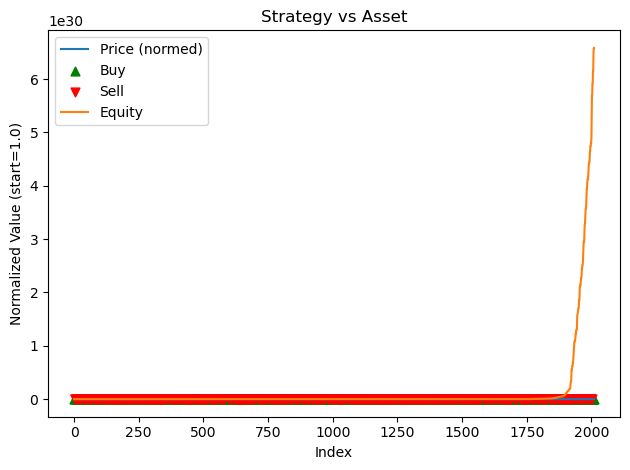

In [365]:
#Plot backtest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_equity_price_signals(close_prices, equity, signals, dates=None, title="Strategy vs Asset"):
    cp = np.asarray(close_prices, dtype=float).reshape(-1)
    eq = np.asarray(equity, dtype=float).reshape(-1)
    sig = np.asarray(signals, dtype=int).reshape(-1)
    if not (len(cp) == len(eq) == len(sig)):
        raise ValueError(f"Length mismatch: price={len(cp)}, equity={len(eq)}, signals={len(sig)}")

    # Normalize price to start at 1.0
    cp_norm = cp / cp[0]

    # Handle dates
    if dates is None:
        x = np.arange(len(cp))
        x_for_scatter = x
        xlabel = "Index"
    else:
        idx = pd.to_datetime(pd.Index(dates))
        x = idx
        x_for_scatter = np.array(idx)
        xlabel = "Date"

    buys  = sig == 1
    sells = sig == -1

    fig, ax = plt.subplots()

    # Plot normalized price
    ax.plot(x, cp_norm, label="Price (normed)", color="tab:blue")
    ax.scatter(x_for_scatter[buys],  cp_norm[buys],  marker="^", s=40, label="Buy", color="green")
    ax.scatter(x_for_scatter[sells], cp_norm[sells], marker="v", s=40, label="Sell", color="red")

    # Plot equity
    ax.plot(x, eq, label="Equity", color="tab:orange")

    ax.set_xlabel(xlabel)
    ax.set_ylabel("Normalized Value (start=1.0)")
    ax.legend(loc="best")

    plt.title(title)
    plt.tight_layout()
    plt.show()



# Convenience wrapper if you pass the backtest output directly
def plot_from_backtest(bt):
    """
    bt: dict returned by backtest_1day_leverage(...) OR a DataFrame with
        columns ['close','equity','signal'] and a DatetimeIndex.
    """
    if isinstance(bt, dict):
        return plot_equity_price_signals(bt["close"], bt["equity"], bt["signal"])
    else:
        return plot_equity_price_signals(
            bt["close"].to_numpy(),
            bt["equity"].to_numpy(),
            bt["signal"].to_numpy(),
            dates=bt.index
        )

# If you have the dict from backtest_1day_leverage(...)
plot_from_backtest(backtest)

In [246]:
#Generate winrate
wins = [0] * 2011
rets = backtest["daily_ret"]
i=0
for ret in rets:
    if ret > 0:
        wins[i] = 1
    i+=1
wins_filtered = [val for val, flag in zip(wins, signals) if flag != 0]
winrate = sum(wins_filtered) / len(wins_filtered)
print(str(winrate*100)+"%")

58.42339478703115%


So, in-sample, we have a 58% win rate in our trades. Here we are allocating our entire portfolio every time. So technically if SPY drops by 20%, our portfolio is gone. Let's now go back, rerun everything 250 days missing, and see how we perform.

In [266]:
spy_shift_2 = close_series.shift(-1)
spy_shift_2 = spy_shift.iloc[:-250]
features_shift_2 = features.iloc[:-251]

scaler = StandardScaler()
features_shiftscaled = scaler.fit_transform(features_shift_2)
""""
NOTICE NOTICE NOTICE NOTICE NOTICE NOTICE NOTICE NOTICE NOTICE NOTICE NOTICE NOTICE 

#################################################################
GENERATE MODEL ONLY WHEN YOU ARE SURE YOU ARE SURE. EXTREMELY SLOW AND INTENSIVE PROGRAM.
GENERATE MODEL ONLY WHEN YOU ARE SURE YOU ARE SURE. EXTREMELY SLOW AND INTENSIVE PROGRAM.
GENERATE MODEL ONLY WHEN YOU ARE SURE YOU ARE SURE. EXTREMELY SLOW AND INTENSIVE PROGRAM.
#################################################################

NOTICE NOTICE NOTICE NOTICE NOTICE NOTICE NOTICE NOTICE NOTICE NOTICE NOTICE NOTICE 
"""
### GENERATE MODEL ###
model = ElasticNetCV(
    l1_ratio=np.linspace(0.0, 1.0, 20),  # α grid (0 = Ridge, 1 = Lasso)
    alphas=np.logspace(-4, 2, 50),       # λ grid
    cv=4,                               # 4-fold CV
    max_iter=10000,
    n_jobs=-1
)

model.fit(features_shift_2, spy_shift_2)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: UserWarning: Coordinate desc

ElasticNetCV(alphas=array([1.00000000e-04, 1.32571137e-04, 1.75751062e-04, 2.32995181e-04,
       3.08884360e-04, 4.09491506e-04, 5.42867544e-04, 7.19685673e-04,
       9.54095476e-04, 1.26485522e-03, 1.67683294e-03, 2.22299648e-03,
       2.94705170e-03, 3.90693994e-03, 5.17947468e-03, 6.86648845e-03,
       9.10298178e-03, 1.20679264e-02, 1.59985872e-02, 2.12095089e-02,
       2.81176870e-02, 3.727593...
       7.90604321e+00, 1.04811313e+01, 1.38949549e+01, 1.84206997e+01,
       2.44205309e+01, 3.23745754e+01, 4.29193426e+01, 5.68986603e+01,
       7.54312006e+01, 1.00000000e+02]),
             cv=4,
             l1_ratio=array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
             max_iter=10000, n_jobs=-1)

In [367]:
#Print model results (copy from earlier because model was overwritten in second test)
print(f"Optimal lambda (sklearn alpha): {model.alpha_:.6f}")
print(f"Optimal l1_ratio (mixing parameter): {model.l1_ratio_:.3f}")
print(f"Train R^2: {model.score(features_shift, spy_shift):.3f}")
print(f"Test  R^2: {model.score(features_shift, spy_shift):.3f}")

Optimal lambda (sklearn alpha): 0.152642
Optimal l1_ratio (mixing parameter): 1.000
Train R^2: 0.998
Test  R^2: 0.998


In [369]:
#Generate out of sample backtest
test_x = features_shift.iloc[-249:]
oos_predictions = model.predict(test_x)
oos_chngpct = (oos_predictions[1:] - oos_predictions[:-1]) / oos_predictions[:-1]
oos_chngpct = oos_chngpct * 100
i=0
signals_oos = [0]*249
for prediction in oos_chngpct:
    if prediction > .25:
        signals_oos[i] = 1
    elif prediction < -.25:
        signals_oos[i] = -1
    i += 1
spy_oos = spy_shift.iloc[-249:]
backtest_oos = backtest_1day_leverage(spy_oos, signals_oos)

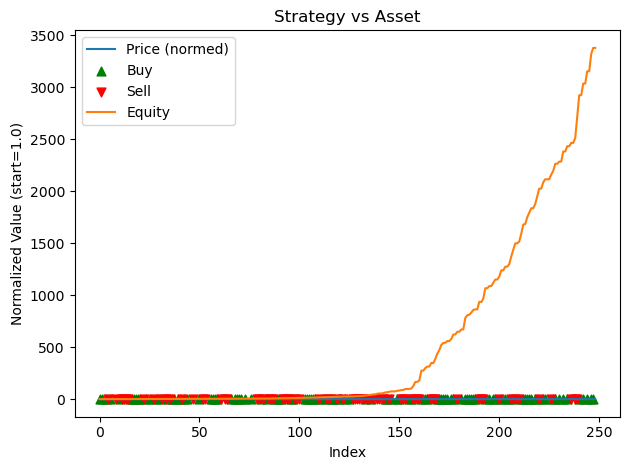

In [316]:
plot_from_backtest(backtest_oos)

Wow! So this strategy may be viable after all! Let's get some performance metrics.

In [320]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns





def tangency_weights(returns,dropna=True,scale_cov=1):
    if dropna:
        returns = returns.dropna()

    covmat_full = returns.cov()
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full + (1-scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat,returns.mean())
    weights = weights / weights.sum()

    return pd.DataFrame(weights, index=returns.columns,columns=['tangency weights'])


        

def performanceMetrics(returns,annualization=1, quantile=.05):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Mean'] = returns.mean() * annualization
    metrics['Vol'] = returns.std() * np.sqrt(annualization)
    metrics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(annualization)

    metrics['Min'] = returns.min()
    metrics['Max'] = returns.max()
    return metrics





def display_correlation(df,list_maxmin=True):
    
    corrmat = df.corr()
    #ignore self-correlation
    corrmat[corrmat==1] = None
    sns.heatmap(corrmat)

    if list_maxmin:
        corr_rank = corrmat.unstack().sort_values().dropna()
        pair_max = corr_rank.index[-1]
        pair_min = corr_rank.index[0]

        print(f'MIN Correlation pair is {pair_min}')
        print(f'MAX Correlation pair is {pair_max}')
        
    return

        
        
def maximumDrawdown(returns):
    cum_returns = (1 + returns).cumprod()
    rolling_max = cum_returns.cummax()
    drawdown = (cum_returns - rolling_max) / rolling_max

    max_drawdown = drawdown.min()
    end_date = drawdown.idxmin()
    summary = pd.DataFrame({'Max Drawdown': max_drawdown, 'Bottom': end_date})

    for col in drawdown:
        summary.loc[col,'Peak'] = (rolling_max.loc[:end_date[col],col]).idxmax()
        recovery = (drawdown.loc[end_date[col]:,col])
        try:
            summary.loc[col,'Recover'] = pd.to_datetime(recovery[recovery >= 0].index[0])
        except:
            summary.loc[col,'Recover'] = pd.to_datetime(None)

        summary['Peak'] = pd.to_datetime(summary['Peak'])
        try:
            summary['Duration (to Recover)'] = (summary['Recover'] - summary['Peak'])
        except:
            summary['Duration (to Recover)'] = None
            
        summary = summary[['Max Drawdown','Peak','Bottom','Recover','Duration (to Recover)']]

    return summary    




def tailMetrics(returns, quantile=.05, relative=False, mdd=True):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Skewness'] = returns.skew()
    metrics['Kurtosis'] = returns.kurtosis()

    VaR = returns.quantile(quantile)
    CVaR = (returns[returns < returns.quantile(quantile)]).mean()

    if relative:
        VaR = (VaR - returns.mean())/returns.std()
        CVaR = (CVaR - returns.mean())/returns.std()

    metrics[f'VaR ({quantile})'] = VaR
    metrics[f'CVaR ({quantile})'] = CVaR

    if mdd:
        mdd_stats = maximumDrawdown(returns)
        metrics = metrics.join(mdd_stats)

        if relative:
            metrics['Max Drawdown'] = (metrics['Max Drawdown'] - returns.mean())/returns.std()

    return metrics






def get_ols_metrics(regressors, targets, annualization=1, ignorenan=True):
    # ensure regressors and targets are pandas dataframes, as expected
    if not isinstance(regressors, pd.DataFrame):
        regressors = regressors.to_frame()
    if not isinstance(targets, pd.DataFrame):
        targets = targets.to_frame()

    # align the targets and regressors on the same dates
    df_aligned = targets.join(regressors, how='inner', lsuffix='y ')
    Y = df_aligned[targets.columns]
    Xset = df_aligned[regressors.columns]

    reg = pd.DataFrame(index=targets.columns)
    for col in Y.columns:
        y = Y[col]
        
        if ignorenan:
            # ensure we use only non-NaN dates
            alldata = Xset.join(y,lsuffix='X')
            mask = alldata.notnull().all(axis=1)
            y = y[mask]
            X = Xset[mask]
        else:
            X = Xset

        model = LinearRegression().fit(X, y)
        reg.loc[col, 'alpha'] = model.intercept_ * annualization
        reg.loc[col, regressors.columns] = model.coef_
        reg.loc[col, 'r-squared'] = model.score(X, y)

        # sklearn does not return the residuals, so we need to build them
        yfit = model.predict(X)
        residuals = y - yfit

        num_roundoff = 1e-12
        
        # Treynor Ratio is only defined for univariate regression
        if Xset.shape[1] == 1:
            if np.abs(model.coef_) < num_roundoff:
                reg.loc[col,'Treynor Ratio'] = None
            else:
                reg.loc[col,'Treynor Ratio'] = (y.mean() / model.coef_) * annualization

        
        # if intercept =0, numerical roundoff will nonetheless show nonzero Info Ratio        
        if np.abs(model.intercept_) < num_roundoff:
            reg.loc[col, 'Info Ratio'] = None
        else:
            reg.loc[col, 'Info Ratio'] = (model.intercept_ / residuals.std()) * np.sqrt(annualization)

    return reg





def penalized_reg_limit_gross(func, X, y, limit=2, penalty=1e-6, fit_intercept=True):
    wts = np.ones(X.shape[1]) * 100
    
    while np.abs(wts).sum()>limit:
        penalty *= 1.1
        model = func(alpha=penalty, fit_intercept=fit_intercept).fit(X,y)
        wts = model.coef_ / model.coef_.sum()
    
    return wts, penalty



def penalized_reg_limit_X(func, X, y, limit=10, penalty=1e-6, fit_intercept=True):
    wts = np.ones(X.shape[1]) * 100
    
    Nx = np.inf
    while Nx>limit:
        penalty *= 1.1
        model = func(alpha=penalty, fit_intercept=fit_intercept).fit(X,y)
        wts = model.coef_ / model.coef_.sum()
    
        if func is Lasso:
            Nx = (np.abs(wts)>1e-4).sum()            
        else:
            Nx = 0
            
    return wts, penalty






import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

In [348]:
wins_oos = [0] * 250
rets_oos = backtest_oos["daily_ret"]
i=0
for ret in rets_oos:
    if ret > 0:
        wins_oos[i] = 1
    i+=1
wins_filtered = [val for val, flag in zip(wins_oos, signals_oos) if flag != 0]
winrate_oos = sum(wins_filtered) / len(wins_filtered)

In [350]:
metrics = performanceMetrics(pd.DataFrame(backtest_oos["daily_ret"]), annualization=365)
print(metrics)
print(str(winrate_oos*100)+"%")


       Mean       Vol    Sharpe       Min       Max
0  0.269224  0.238522  1.128719 -0.058543  0.105019
61.32596685082873%


This is really cool. We're not using a rolling window either, so we might actually be able to improve this strategy with more compute time. For the scope of this project, however, it's unrealistic to reoptimize for every day. Strangely, our prediction accuracy actually improves for the out of sample data, perhaps we're just lucky.